Steane Codewords for |0_L> (from p=0 simulation):
  Codeword | H * c (mod 2)
  0000000 | [0, 0, 0] (Valid)
  0010111 | [0, 0, 0] (Valid)
  0101101 | [0, 0, 0] (Valid)
  0111010 | [0, 0, 0] (Valid)
  1001011 | [0, 0, 0] (Valid)
  1011100 | [0, 0, 0] (Valid)
  1100110 | [0, 0, 0] (Valid)
  1110001 | [0, 0, 0] (Valid)

p = 0.000
Computational Basis States and Probabilities:
  Codewords (|0_L> components):
    0000000: 0.1160
    0010111: 0.1440
    0101101: 0.1200
    0111010: 0.1310
    1001011: 0.1260
    1011100: 0.1150
    1100110: 0.1300
    1110001: 0.1180
  Non-codewords:
    None
Total Probability of |0_L> (Codewords): 1.0000

p = 0.037
Computational Basis States and Probabilities:
  Codewords (|0_L> components):
    0000000: 0.1000
    0010111: 0.1210
    0101101: 0.1170
    0111010: 0.1070
    1001011: 0.1060
    1011100: 0.1160
    1100110: 0.1230
    1110001: 0.1250
  Non-codewords:
    0001110: 0.0130
    0011001: 0.0110
    0100011: 0.0090
    0110100: 0.0180
    1000101: 0.

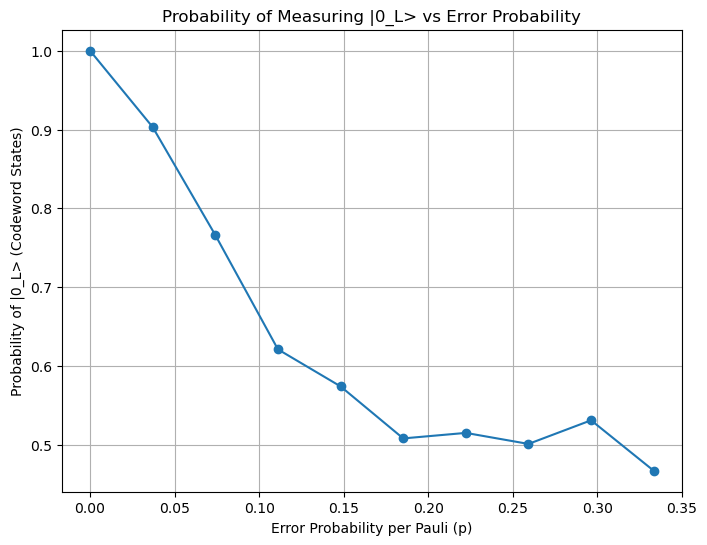

<Figure size 640x480 with 0 Axes>

In [9]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# Define the parity-check matrix for the [7,4,3] Hamming code used in Steane code
H = np.array([[1, 0, 0, 1, 0, 1, 1],
              [0, 1, 0, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 1, 1]])

def create_steane_circuit(x, p, apply_errors=True):
    """
    Creates a Qiskit circuit for the Steane code: prepares |x_L> (|0_L> or |1_L> based on x),
    applies a Pauli error channel, measures syndromes, applies recovery, and measures data qubits.
    
    Args:
        x (list): 7-bit Boolean vector to determine |0_L> or |1_L>.
        p (float): Error probability per Pauli error (X, Y, or Z, each with probability p).
        apply_errors (bool): If True, apply error channel; if False, skip errors (for p=0).
    
    Returns:
        QuantumCircuit: The constructed circuit with preparation, errors, syndrome measurement,
                        recovery, and data qubit measurement.
    """
    # Validate inputs
    if len(x) != 7 or not all(xi in [0, 1] for xi in x):
        raise ValueError("x must be a 7-bit vector of 0s and 1s")
    if not 0 <= p <= 1/3:
        raise ValueError("p must be between 0 and 1/3")
    
    # Initialize quantum and classical registers
    data = QuantumRegister(7, name="data")  # 7 data qubits for Steane code
    x_anc = QuantumRegister(3, name="x_anc")  # 3 ancilla qubits for X-stabilizers
    z_anc = QuantumRegister(3, name="z_anc")  # 3 ancilla qubits for Z-stabilizers
    x_synd = ClassicalRegister(3, name="s_x")  # 3 bits for X-stabilizer syndromes
    z_synd = ClassicalRegister(3, name="s_z")  # 3 bits for Z-stabilizer syndromes
    meas = ClassicalRegister(7, name="meas")  # 7 bits for data qubit measurements
    circuit = QuantumCircuit(data, x_anc, z_anc, x_synd, z_synd, meas)
    
    # Prepare |0_L> state using Hadamard and CNOT gates based on parity-check matrix H
    circuit.h(data[:3])  # Apply Hadamard to qubits 0, 1, 2 to create superposition
    circuit.cx(data[0], data[3])  # CNOTs to enforce parity checks
    circuit.cx(data[0], data[5])
    circuit.cx(data[0], data[6])
    circuit.cx(data[1], data[3])
    circuit.cx(data[1], data[4])
    circuit.cx(data[1], data[6])
    circuit.cx(data[2], data[4])
    circuit.cx(data[2], data[5])
    circuit.cx(data[2], data[6])
    circuit.barrier()
    
    # Apply logical X operator (X on all 7 qubits) if x is not a codeword
    is_codeword = np.all((H @ np.array(x)) % 2 == 0)
    if not is_codeword:
        circuit.x(data[0:7])  # Prepare |1_L> by applying X_L
    circuit.barrier()
    
    # Apply Pauli error channel (X, Y, or Z with probability p each, none with 1-3p)
    if apply_errors:
        for i in range(7):
            error = np.random.choice(['none', 'X', 'Y', 'Z'], p=[1-3*p, p, p, p])
            if error == 'X':
                circuit.x(data[i])
            elif error == 'Y':
                circuit.y(data[i])
            elif error == 'Z':
                circuit.z(data[i])
    circuit.barrier()
    
    # Measure syndromes for X- and Z-stabilizers
    for idx, row in enumerate(H):
        # X-stabilizers (detect Z errors)
        circuit.h(x_anc[idx])  # Hadamard to measure X-stabilizer
        for qubit_idx in np.where(row)[0]:
            circuit.cx(x_anc[idx], data[qubit_idx])  # CNOTs based on H matrix
        circuit.h(x_anc[idx])
        circuit.measure(x_anc[idx], x_synd[idx])
        # Z-stabilizers (detect X errors)
        for qubit_idx in np.where(row)[0]:
            circuit.cx(data[qubit_idx], z_anc[idx])  # CNOTs based on H matrix
        circuit.measure(z_anc[idx], z_synd[idx])
    circuit.barrier()
    
    # Apply recovery operations based on syndrome measurements
    with circuit.if_test((x_synd, 1)): circuit.z(data[0])  # Correct Z errors
    with circuit.if_test((x_synd, 2)): circuit.z(data[1])
    with circuit.if_test((x_synd, 4)): circuit.z(data[2])
    with circuit.if_test((x_synd, 3)): circuit.z(data[3])
    with circuit.if_test((x_synd, 6)): circuit.z(data[4])
    with circuit.if_test((x_synd, 5)): circuit.z(data[5])
    with circuit.if_test((x_synd, 7)): circuit.z(data[6])
    with circuit.if_test((z_synd, 1)): circuit.x(data[0])  # Correct X errors
    with circuit.if_test((z_synd, 2)): circuit.x(data[1])
    with circuit.if_test((z_synd, 4)): circuit.x(data[2])
    with circuit.if_test((z_synd, 3)): circuit.x(data[3])
    with circuit.if_test((z_synd, 6)): circuit.x(data[4])
    with circuit.if_test((z_synd, 5)): circuit.x(data[5])
    with circuit.if_test((z_synd, 7)): circuit.x(data[6])
    circuit.barrier()
    
    # Measure all data qubits to obtain the final state
    circuit.measure(data, meas)
    
    return circuit

def simulate_steane_circuit(x, p, shots=1000):
    """
    Simulates the Steane code circuit and returns the distribution of computational basis states.
    
    Args:
        x (list): 7-bit Boolean vector to determine |0_L> or |1_L>.
        p (float): Error probability per Pauli error.
        shots (int): Number of simulation shots.
    
    Returns:
        dict: Dictionary mapping 7-bit data qubit states (big-endian) to their probabilities.
    """
    counts = {}
    simulator = AerSimulator()  # Initialize Qiskit Aer simulator
    
    # Run each shot with a new circuit to apply random errors independently
    for _ in range(shots):
        circuit = create_steane_circuit(x, p, apply_errors=(p > 0))
        job = simulator.run(circuit, shots=1)
        result = job.result().get_counts()
        for bitstring in result:
            # Extract data qubits (meas), reverse for big-endian (Qiskit outputs little-endian)
            meas_key = bitstring.split()[0][::-1]
            counts[meas_key] = counts.get(meas_key, 0) + result[bitstring]
    
    # Convert counts to probabilities
    distribution = {key: count / shots for key, count in counts.items()}
    return distribution

def verify_codewords(codewords):
    """
    Verifies that each codeword satisfies H * c = 0 (mod 2) for |0_L>.
    
    Args:
        codewords (list): List of 7-bit binary strings.
    
    Returns:
        dict: Dictionary mapping codewords to their H * c result (mod 2).
    """
    verification_results = {}
    for c in codewords:
        c_vector = np.array([int(bit) for bit in c])  # Convert string to binary vector
        result = (H @ c_vector) % 2  # Compute H * c mod 2
        verification_results[c] = result.tolist()
    return verification_results

def get_codewords(x, shots=10000):
    """
    Runs the circuit with p=0 to collect the computational basis states (codewords) for |0_L>.
    
    Args:
        x (list): 7-bit Boolean vector (should be [0,0,0,0,0,0,0] for |0_L>).
        shots (int): Number of simulation shots (high to capture all codewords).
    
    Returns:
        list: Sorted list of 7-bit codewords observed in the simulation.
    """
    distribution = simulate_steane_circuit(x, p=0, shots=shots)
    codewords = sorted(distribution.keys())  # Sort for consistent output
    return codewords

def analyze_distribution(x, p_values, shots=1000):
    """
    Analyzes the distribution of computational basis states for x = [0,0,0,0,0,0,0] and various p.
    
    Args:
        x (list): 7-bit Boolean vector (fixed to [0,0,0,0,0,0,0] for |0_L>).
        p_values (list): List of error probabilities to test.
        shots (int): Number of simulation shots.
    """
    # Verify x is [0,0,0,0,0,0,0] for |0_L>
    if x != [0,0,0,0,0,0,0]:
        print("Warning: Analysis is for x = [0,0,0,0,0,0,0] (|0_L>) only")
        return
    
    # Get codewords for |0_L> from p=0 simulation
    codewords = get_codewords(x, shots=10000)
    print("Steane Codewords for |0_L> (from p=0 simulation):")
    print("  Codeword | H * c (mod 2)")
    verification_results = verify_codewords(codewords)
    for state in codewords:
        result = verification_results[state]
        print(f"  {state} | {result} {'(Valid)' if np.all(result == [0, 0, 0]) else '(Invalid)'}")
    
    # Analyze distribution for each p
    for p in p_values:
        print(f"\np = {p:.3f}")
        distribution = simulate_steane_circuit(x, p, shots)
        print("Computational Basis States and Probabilities:")
        total_codeword_prob = 0
        print("  Codewords (|0_L> components):")
        for state in codewords:
            prob = distribution.get(state, 0.0)
            if prob > 0:
                print(f"    {state}: {prob:.4f}")
                total_codeword_prob += prob
        print("  Non-codewords:")
        non_codeword_states = [state for state in distribution.keys() if state not in codewords]
        if non_codeword_states:
            for state in sorted(non_codeword_states):
                prob = distribution.get(state, 0.0)
                if prob > 0:
                    print(f"    {state}: {prob:.4f}")
        else:
            print("    None")
        print(f"Total Probability of |0_L> (Codewords): {total_codeword_prob:.4f}")
    
    # Plot total codeword probability
    codeword_probs = []
    for p in p_values:
        distribution = simulate_steane_circuit(x, p, shots)
        total_codeword_prob = sum(distribution.get(state, 0.0) for state in codewords)
        codeword_probs.append(total_codeword_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(p_values, codeword_probs, marker='o')
    plt.xlabel('Error Probability per Pauli (p)')
    plt.ylabel('Probability of |0_L> (Codeword States)')
    plt.title('Probability of Measuring |0_L> vs Error Probability')
    plt.grid(True)
    plt.show()
    plt.savefig('my_plot.png')

if __name__ == "__main__":
    x = [0,0,0,0,0,0,0]  # Fixed to |0_L>
    p_values = np.linspace(0, 1/3, 10)  # Error probabilities from 0 to 1/3
    analyze_distribution(x, p_values, shots=1000)

In [11]:
# sample quantum circuit for steane's code under random pauli error. 
qc_ex = create_steane_circuit([0,0,0,0,0,0,0], 1/4)

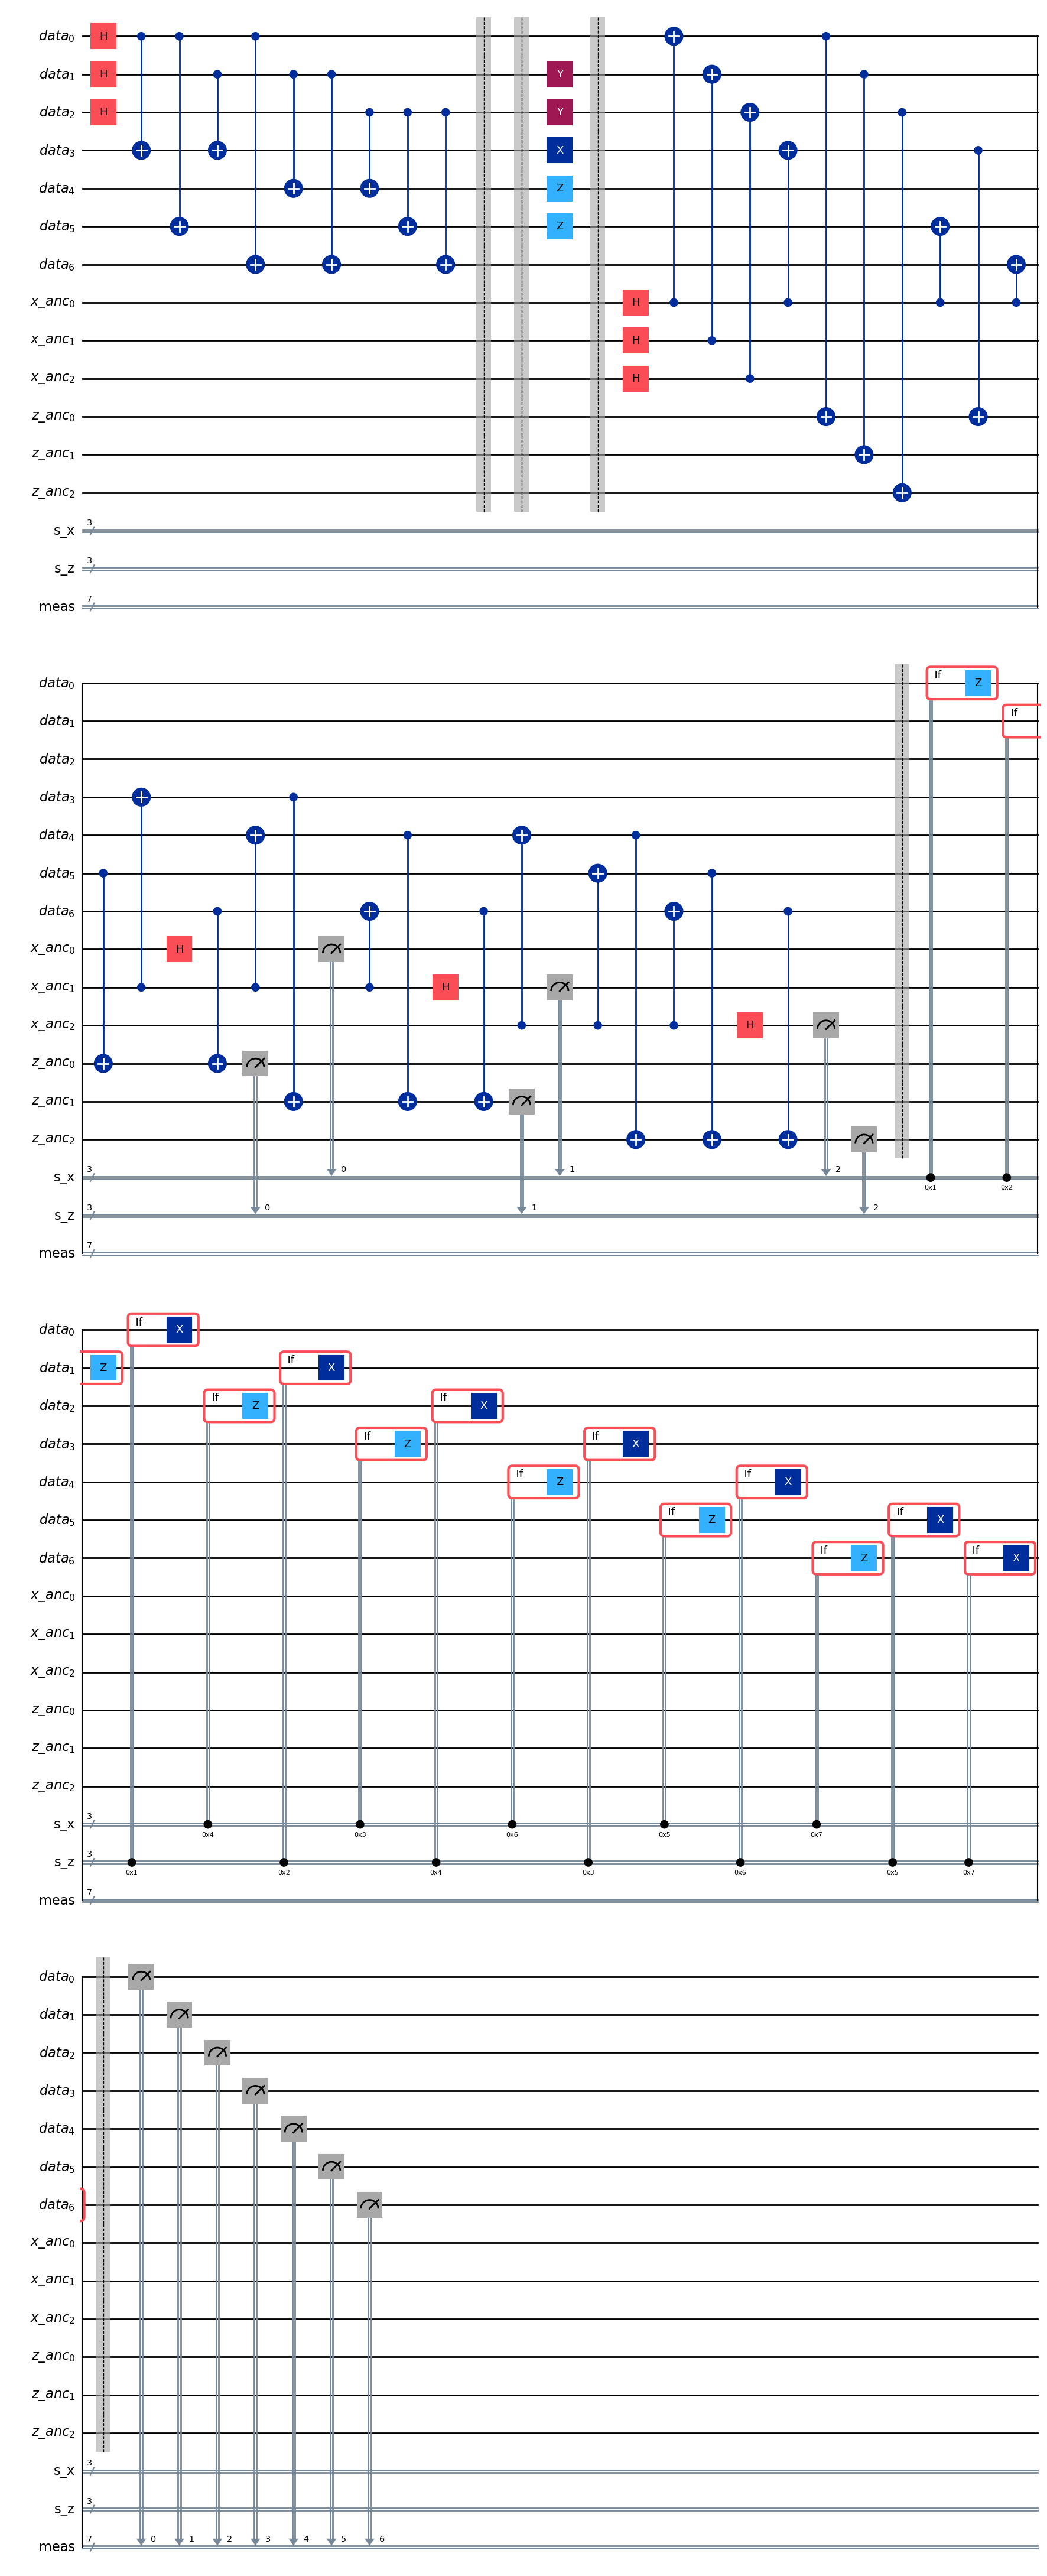

In [13]:
qc_ex.draw("mpl")